In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
import seaborn as sns
from scipy import stats
import warnings
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import cross_val_score
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
training_data = pd.read_csv('/Users/brendanferris/Desktop/kings_county_housing/kc_house_data_train.csv')
bedroomsfilled = pd.read_csv('/Users/brendanferris/Desktop/kings_county_housing/EDA/bedroomsfilled.csv')
census_data = pd.read_excel('/Users/brendanferris/Desktop/kings_county_housing/EDA/extradata.xlsx')
training_data.drop('Unnamed: 0', axis=1, inplace=True)
bedroomsfilled.drop('Unnamed: 0', axis=1, inplace=True)
#census_data.drop('Unnamed: 0', axis=1, inplace=True)

In [3]:
training_data.shape, bedroomsfilled.shape, census_data.shape

((17290, 21), (12, 21), (70, 15))

In [4]:
training_data.loc[training_data['bedrooms'] == 0]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
483,3374500520,20150429T000000,355000.0,0,0.00,2460,8049,2.0,0,0,...,8,2460,0,1990,0,98031,47.4095,-122.168,2520,8050
1120,6306400140,20140612T000000,1095000.0,0,0.00,3064,4764,3.5,0,2,...,7,3064,0,1990,0,98102,47.6362,-122.322,2360,4000
2430,1222029077,20141029T000000,265000.0,0,0.75,384,213444,1.0,0,0,...,4,384,0,2003,0,98070,47.4177,-122.491,1920,224341
3032,7849202190,20141223T000000,235000.0,0,0.00,1470,4800,2.0,0,0,...,7,1470,0,1996,0,98065,47.5265,-121.828,1060,7200
3609,2569500210,20141117T000000,339950.0,0,2.50,2290,8319,2.0,0,0,...,8,2290,0,1985,0,98042,47.3473,-122.151,2500,8751
5424,3918400017,20150205T000000,380000.0,0,0.00,1470,979,3.0,0,2,...,8,1470,0,2006,0,98133,47.7145,-122.356,1470,1399
6409,1453602309,20140805T000000,288000.0,0,1.50,1430,1650,3.0,0,0,...,7,1430,0,1999,0,98125,47.7222,-122.290,1430,1650
9286,2954400190,20140624T000000,1295650.0,0,0.00,4810,28008,2.0,0,0,...,12,4810,0,1990,0,98053,47.6642,-122.069,4740,35061
10067,3980300371,20140926T000000,142000.0,0,0.00,290,20875,1.0,0,0,...,1,290,0,1963,0,98024,47.5308,-121.888,1620,22850
10074,2310060040,20140925T000000,240000.0,0,2.50,1810,5669,2.0,0,0,...,7,1810,0,2003,0,98038,47.3493,-122.053,1810,5685


# Fill in missing values.

In [5]:
correct_baths = bedroomsfilled.bathrooms.to_list()
correct_beds = bedroomsfilled.bedrooms.to_list()
ind = training_data.loc[training_data.bedrooms == 0].index.to_list()

new_col = pd.Series(correct_beds, name='bedrooms', index=ind)
new_col2 = pd.Series(correct_baths, name='bathrooms', index=ind)

training_data.update(new_col)
training_data.update(new_col2)

In [6]:
training_data.shape

(17290, 21)

In [7]:
training_data.columns.to_list()

['id',
 'date',
 'price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15']

# Removing Outliers

In [8]:
def clean_beds(dataframe):
    median_beds = dataframe.bedrooms.median()
    dataframe['bedrooms'].values[dataframe['bedrooms'].values > 10] = median_beds
    print('Entries with an abnormal amount of bedrooms have been replaced with {}, the median number of bedrooms in the dataframe. \n'.format(median_beds))

In [9]:
clean_beds(training_data)

Entries with an abnormal amount of bedrooms have been replaced with 3.0, the median number of bedrooms in the dataframe. 



 # Adding additional zipcode information

In [10]:
#training_data = pd.merge(training_data, census_data, left_on='zipcode', right_on='zipcode')

 # Adding Features

In [11]:
training_data['home_age'] =  2015 - training_data.yr_built
#training_data['available_housing'] = training_data['total_housing_units'] - training_data['occupied_housing_units']

#turning date into datetime so we can extract sale year/month
training_data['date'] = pd.to_datetime(training_data['date'])

training_data['sale_year'] = pd.DatetimeIndex(training_data['date']).year
training_data['sale_month'] = pd.DatetimeIndex(training_data['date']).month
training_data.drop(columns='date', inplace=True)

##### Dummy Features for categorical variables.

In [12]:
waterfront_dummies = pd.get_dummies(training_data['waterfront'], prefix='waterf', drop_first=True)
view_dummies = pd.get_dummies(training_data['view'], prefix='has_view', drop_first=True)
condition_dummies = pd.get_dummies(training_data['condition'], prefix='condition', drop_first=True)
grade_dummies = pd.get_dummies(training_data['grade'], prefix='grade', drop_first=True)
month_dummies = pd.get_dummies(training_data['sale_month'], prefix='month', drop_first=True)
zip_dummies = pd.get_dummies(training_data['zipcode'], prefix='zip', drop_first=True)

In [13]:
training_data = training_data.drop(['id','zipcode','sale_month','waterfront', 'view', 'condition', 'grade'], axis=1) #dropped postoffice
training_data = pd.concat([training_data, waterfront_dummies, view_dummies, condition_dummies, grade_dummies, month_dummies, zip_dummies], axis=1)

# Removing Colinear Features

In [14]:
def multicolinear_features(data):
    '''
    input: dataframe
    returns a dataframe of all colinear features in a dataframe.
    '''

    df=data.corr().abs().stack().reset_index().sort_values(0, ascending=False)
    df['pairs'] = list(zip(df.level_0, df.level_1))
    df.set_index(['pairs'], inplace = True)
    df.drop(columns=['level_1', 'level_0'], inplace = True)
    df.columns = ['cc']
    return df[(df.cc>.75) & (df.cc <1)]

In [15]:
multicolinear_features(training_data)

,cc
pairs,
"(sqft_living, sqft_above)",0.876696
"(sqft_above, sqft_living)",0.876696
"(condition_3, condition_4)",0.810849
"(condition_4, condition_3)",0.810849
"(bathrooms, sqft_living)",0.756908
"(sqft_living, bathrooms)",0.756908
"(sqft_living, sqft_living15)",0.755066
"(sqft_living15, sqft_living)",0.755066


In [16]:
training_data.drop([#'zip_98003',
                    #'owned_household_with_mortgage', 
                    #'houses_owned_outright',
                    #'land_area',
                    #'occupied_housing_units',
                    #'total_housing_units',
                    'sqft_living', 
                    'condition_3'], axis=1, inplace=True)

In [17]:
multicolinear_features(training_data) # Should be empty

,cc
pairs,


In [18]:
training_data.columns.to_list()

['price',
 'bedrooms',
 'bathrooms',
 'sqft_lot',
 'floors',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15',
 'home_age',
 'sale_year',
 'waterf_1',
 'has_view_1',
 'has_view_2',
 'has_view_3',
 'has_view_4',
 'condition_2',
 'condition_4',
 'condition_5',
 'grade_3',
 'grade_4',
 'grade_5',
 'grade_6',
 'grade_7',
 'grade_8',
 'grade_9',
 'grade_10',
 'grade_11',
 'grade_12',
 'grade_13',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'month_11',
 'month_12',
 'zip_98002',
 'zip_98003',
 'zip_98004',
 'zip_98005',
 'zip_98006',
 'zip_98007',
 'zip_98008',
 'zip_98010',
 'zip_98011',
 'zip_98014',
 'zip_98019',
 'zip_98022',
 'zip_98023',
 'zip_98024',
 'zip_98027',
 'zip_98028',
 'zip_98029',
 'zip_98030',
 'zip_98031',
 'zip_98032',
 'zip_98033',
 'zip_98034',
 'zip_98038',
 'zip_98039',
 'zip_98040',
 'zip_98042',
 'zip_98045',
 'zip_98052',
 'zip_98053',
 

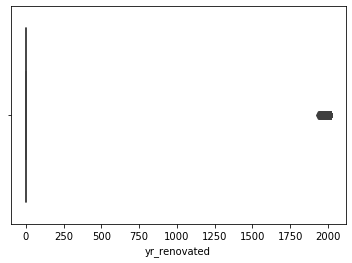

In [19]:
sns.boxplot(training_data.yr_renovated)

In [20]:
#training_data.drop(['water_area_sq_mile', 'pop_density','available_housing', 'yr_renovated'] , axis=1, inplace=True)

# Adding polynomial features.

In [21]:
poly_feats = PolynomialFeatures(degree=2, include_bias=False)
poly_data = poly_feats.fit_transform(training_data.drop(columns='price', axis=1))
poly_columns = poly_feats.get_feature_names(training_data.columns.drop('price'))
df_poly = pd.DataFrame(poly_data, columns=poly_columns)
df_poly.shape

(17290, 6554)

In [22]:
y = training_data.price

# Train/test split

In [23]:
X_train, X_test, y_train, y_test = train_test_split(df_poly, y, random_state=9,test_size=0.2)

In [24]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((13832, 6554), (3458, 6554), (13832,), (3458,))

# Selecting the best features.

In [25]:
selector = SelectKBest(f_regression, k=250)

selector.fit(X_train, y_train)

selected_columns = X_train.columns[selector.get_support()]
removed_columns = X_train.columns[~selector.get_support()]

In [26]:
#instantiate
lm_kbest = LinearRegression()

#fit
lm_kbest = lm_kbest.fit(X_train[selected_columns], y_train)

y_train_kbest = lm_kbest.predict(X_train[selected_columns])


trainK_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_kbest))


print('Training Root Mean Squared Error:' , trainK_rmse)

y_kbest = lm_kbest.predict(X_test[selected_columns])

testK_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_kbest))

print('Testing Root Mean Squared Error:' , testK_rmse)

Training Root Mean Squared Error: 136362.63170781927
Testing Root Mean Squared Error: 321254.4348260275


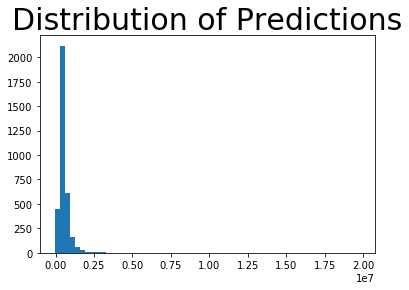

In [27]:
plt.hist(y_kbest, bins=60);
plt.title('Distribution of Predictions', size=30);

In [28]:
selected_columns.to_list()

['bedrooms',
 'bathrooms',
 'floors',
 'sqft_above',
 'sqft_basement',
 'lat',
 'sqft_living15',
 'waterf_1',
 'has_view_4',
 'grade_6',
 'grade_7',
 'grade_9',
 'grade_10',
 'grade_11',
 'grade_12',
 'grade_13',
 'zip_98004',
 'zip_98039',
 'zip_98040',
 'bedrooms^2',
 'bedrooms bathrooms',
 'bedrooms floors',
 'bedrooms sqft_above',
 'bedrooms sqft_basement',
 'bedrooms yr_built',
 'bedrooms lat',
 'bedrooms long',
 'bedrooms sqft_living15',
 'bedrooms sale_year',
 'bedrooms waterf_1',
 'bedrooms has_view_3',
 'bedrooms has_view_4',
 'bedrooms grade_6',
 'bedrooms grade_7',
 'bedrooms grade_9',
 'bedrooms grade_10',
 'bedrooms grade_11',
 'bedrooms grade_12',
 'bedrooms grade_13',
 'bedrooms zip_98004',
 'bedrooms zip_98039',
 'bedrooms zip_98040',
 'bedrooms zip_98112',
 'bathrooms^2',
 'bathrooms floors',
 'bathrooms sqft_above',
 'bathrooms sqft_basement',
 'bathrooms yr_built',
 'bathrooms yr_renovated',
 'bathrooms lat',
 'bathrooms long',
 'bathrooms sqft_living15',
 'bathrooms

# Final Model

In [29]:
#Instantiate a linear regression object
#lm_final = LinearRegression()

#Fit the linear regression to the data
lm_final = lm_kbest.fit(df_poly[selected_columns], training_data.price)

In [30]:
import pickle


pickle_out = open("final_model.pickle","wb")
pickle.dump(lm_final, pickle_out)
pickle_out.close()

# final_model = pickle.load(open('final_model.pickle', 'rb'))